In [13]:
import os
import glob
import sys
import SimpleITK as sitk
import numpy as np
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

from fastdtw import fastdtw
from scipy import stats, ndimage
from scipy.spatial.distance import euclidean, cdist
from PIL import Image
import cv2
from skimage import morphology
from matplotlib import pyplot as plot
from math import nan
import pandas as pd

## 计算狭窄率
- 对mask进行腐蚀操作，去掉外膜得到正常血管壁的厚度


In [14]:
model_name = "label"
result_dir = f"/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/{model_name}"
file_list = os.listdir(result_dir)
try:
    file_list.remove(".DS_Store")
except ValueError:
    pass
try:
    file_list.remove("._.DS_Store")
except ValueError:
    pass

spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

pn_all = {}
pne_all = {}
mask_all = {}
for idx, file_name in enumerate(file_list):
    if file_name.endswith(".nii.gz"):
        data = sitk.GetArrayFromImage(
            sitk.ReadImage(os.path.join(result_dir, file_name))
        )
    elif file_name.endswith(".npy"):
        data = np.load(os.path.join(result_dir, file_name), allow_pickle=True)
    else:
        print(f"data format {os.path.splitext(file_name)[-1]} is error")
        sys.exit()

    spacing = int(
        spacing_pixels[np.argwhere(spacing_pixels[:, 0] == file_name[:-7])][0][0][1]
    )

    pn = []
    pne = []
    mask = {}
    mask_out_list = []
    mask_in_list = []
    mask_both_list = []
    mask_both_erode_list = []
    for k, img in enumerate(data):
        # pred 腐蚀
        out_mask = np.zeros_like(img)
        out_mask[img == 1] = 1  # 环形mask
        in_mask = np.zeros_like(img)
        in_mask[img == 2] = 1  # 内膜mask
        both_mask = out_mask + in_mask  # 外膜mask
        both_mask_erode = cv2.erode(
            both_mask, kernel=(3, 3), iterations=spacing // 10
        )  # 外膜腐蚀mask

        mask_out_list.append(out_mask)
        mask_in_list.append(in_mask)
        mask_both_list.append(both_mask)
        mask_both_erode_list.append(both_mask_erode)

        pred_narrow = 1 - (np.sum(in_mask) / np.sum(both_mask))
        pred_erode_narrow = 1 - (np.sum(in_mask) / np.sum(both_mask_erode))

        pn.append(pred_narrow)
        pne.append(pred_erode_narrow)

        if False:
            print(
                f"pred_narrow:{pred_narrow:.2f} | pred_narrow:{pred_erode_narrow:.2f}"
            )

    mask["out"] = mask_out_list
    mask["in"] = mask_in_list
    mask["both"] = mask_both_list
    mask["both_erode"] = mask_both_erode_list

    mask_all[file_name] = mask
    pn_all[file_name] = pd.Series(pn)
    pne_all[file_name] = pd.Series(pne)

if False:
    with pd.ExcelWriter(f"{model_name}.xlsx") as writer:
        df_pn_all = pd.DataFrame(data=pn_all)
        df_pn_all.to_excel(
            writer,
            sheet_name="diameter stenosis",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

    with pd.ExcelWriter(f"{model_name}_erode.xlsx") as writer:
        df_pne_all = pd.DataFrame(data=pne_all)
        df_pne_all.to_excel(
            writer,
            sheet_name="diameter stenosis",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

In [15]:
model_name = "rvm"
result_dir = f"/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/{model_name}"
file_list = os.listdir(result_dir)
try:
    file_list.remove(".DS_Store")
except ValueError:
    pass
try:
    file_list.remove("._.DS_Store")
except ValueError:
    pass

spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

pn_rvm_all = {}
pne_rvm_all = {}
mask_rvm_all = {}
for idx, file_name in enumerate(file_list):
    if file_name.endswith(".nii.gz"):
        data = sitk.GetArrayFromImage(
            sitk.ReadImage(os.path.join(result_dir, file_name))
        )
    elif file_name.endswith(".npy"):
        data = np.load(os.path.join(result_dir, file_name), allow_pickle=True)
    else:
        print(f"data format {os.path.splitext(file_name)[-1]} is error")
        sys.exit()

    spacing = int(
        spacing_pixels[np.argwhere(spacing_pixels[:, 0] == file_name[:-7])][0][0][1]
    )

    pn = []
    pne = []
    mask = {}
    mask_out_list = []
    mask_in_list = []
    mask_both_list = []
    mask_both_erode_list = []
    for k, img in enumerate(data):
        # pred 腐蚀
        out_mask = np.zeros_like(img)
        out_mask[img == 1] = 1  # 环形mask
        in_mask = np.zeros_like(img)
        in_mask[img == 2] = 1  # 内膜mask
        both_mask = out_mask + in_mask  # 外膜mask
        both_mask_erode = cv2.erode(
            both_mask, kernel=(3, 3), iterations=spacing // 10
        )  # 外膜腐蚀mask

        mask_out_list.append(out_mask)
        mask_in_list.append(in_mask)
        mask_both_list.append(both_mask)
        mask_both_erode_list.append(both_mask_erode)

        pred_narrow = 1 - (np.sum(in_mask) / np.sum(both_mask))
        pred_erode_narrow = 1 - (np.sum(in_mask) / np.sum(both_mask_erode))

        pn.append(pred_narrow)
        pne.append(pred_erode_narrow)

        if False:
            print(
                f"pred_narrow:{pred_narrow:.2f} | pred_narrow:{pred_erode_narrow:.2f}"
            )

    mask["out"] = mask_out_list
    mask["in"] = mask_in_list
    mask["both"] = mask_both_list
    mask["both_erode"] = mask_both_erode_list

    mask_rvm_all[file_name] = mask
    pn_rvm_all[file_name] = pd.Series(pn)
    pne_rvm_all[file_name] = pd.Series(pne)

if False:
    with pd.ExcelWriter(f"{model_name}.xlsx") as writer:
        df_pn_all = pd.DataFrame(data=pn_rvm_all)
        df_pn_all.to_excel(
            writer,
            sheet_name="diameter stenosis",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

    with pd.ExcelWriter(f"{model_name}_erode.xlsx") as writer:
        df_pne_all = pd.DataFrame(data=pne_rvm_all)
        df_pne_all.to_excel(
            writer,
            sheet_name="diameter stenosis",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

In [16]:
model_name = "3dunet"
result_dir = f"/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/{model_name}"
file_list = os.listdir(result_dir)
try:
    file_list.remove(".DS_Store")
except ValueError:
    pass
try:
    file_list.remove("._.DS_Store")
except ValueError:
    pass

spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

pn_3dunet_all = {}
pne_3dunet_all = {}
mask_3dunet_all = {}
for idx, file_name in enumerate(file_list):
    if file_name.endswith(".nii.gz"):
        data = sitk.GetArrayFromImage(
            sitk.ReadImage(os.path.join(result_dir, file_name))
        )
    elif file_name.endswith(".npy"):
        data = np.load(os.path.join(result_dir, file_name), allow_pickle=True)
    else:
        print(f"data format {os.path.splitext(file_name)[-1]} is error")
        sys.exit()

    spacing = int(
        spacing_pixels[np.argwhere(spacing_pixels[:, 0] == file_name[:-7])][0][0][1]
    )

    pn = []
    pne = []
    mask = {}
    mask_out_list = []
    mask_in_list = []
    mask_both_list = []
    mask_both_erode_list = []
    for k, img in enumerate(data):
        # pred 腐蚀
        out_mask = np.zeros_like(img)
        out_mask[img == 1] = 1  # 环形mask
        in_mask = np.zeros_like(img)
        in_mask[img == 2] = 1  # 内膜mask
        both_mask = out_mask + in_mask  # 外膜mask
        both_mask_erode = cv2.erode(
            both_mask, kernel=(3, 3), iterations=spacing // 10
        )  # 外膜腐蚀mask

        mask_out_list.append(out_mask)
        mask_in_list.append(in_mask)
        mask_both_list.append(both_mask)
        mask_both_erode_list.append(both_mask_erode)

        pred_narrow = 1 - (np.sum(in_mask) / np.sum(both_mask))
        pred_erode_narrow = 1 - (np.sum(in_mask) / np.sum(both_mask_erode))

        pn.append(pred_narrow)
        pne.append(pred_erode_narrow)

        if False:
            print(
                f"pred_narrow:{pred_narrow:.2f} | pred_narrow:{pred_erode_narrow:.2f}"
            )

    mask["out"] = mask_out_list
    mask["in"] = mask_in_list
    mask["both"] = mask_both_list
    mask["both_erode"] = mask_both_erode_list

    mask_3dunet_all[file_name] = mask
    pn_3dunet_all[file_name] = pd.Series(pn)
    pne_3dunet_all[file_name] = pd.Series(pne)

if False:
    with pd.ExcelWriter(f"{model_name}.xlsx") as writer:
        df_pn_all = pd.DataFrame(data=pn_3dunet_all)
        df_pn_all.to_excel(
            writer,
            sheet_name="diameter stenosis",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

    with pd.ExcelWriter(f"{model_name}_erode.xlsx") as writer:
        df_pne_all = pd.DataFrame(data=pne_3dunet_all)
        df_pne_all.to_excel(
            writer,
            sheet_name="diameter stenosis",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

In [17]:
model_name = "transbts"
result_dir = f"/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/{model_name}"
file_list = os.listdir(result_dir)
try:
    file_list.remove(".DS_Store")
except ValueError:
    pass
try:
    file_list.remove("._.DS_Store")
except ValueError:
    pass

spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

pn_transbts_all = {}
pne_transbts_all = {}
mask_transbts_all = {}
for idx, file_name in enumerate(file_list):
    if file_name.endswith(".nii.gz"):
        data = sitk.GetArrayFromImage(
            sitk.ReadImage(os.path.join(result_dir, file_name))
        )
    elif file_name.endswith(".npy"):
        data = np.load(os.path.join(result_dir, file_name), allow_pickle=True)
    else:
        print(f"data format {os.path.splitext(file_name)[-1]} is error")
        sys.exit()

    spacing = int(
        spacing_pixels[np.argwhere(spacing_pixels[:, 0] == file_name[:-7])][0][0][1]
    )

    pn = []
    pne = []
    mask = {}
    mask_out_list = []
    mask_in_list = []
    mask_both_list = []
    mask_both_erode_list = []
    for k, img in enumerate(data):
        # pred 腐蚀
        out_mask = np.zeros_like(img)
        out_mask[img == 1] = 1  # 环形mask
        in_mask = np.zeros_like(img)
        in_mask[img == 2] = 1  # 内膜mask
        both_mask = out_mask + in_mask  # 外膜mask
        both_mask_erode = cv2.erode(
            both_mask, kernel=(3, 3), iterations=spacing // 10
        )  # 外膜腐蚀mask

        mask_out_list.append(out_mask)
        mask_in_list.append(in_mask)
        mask_both_list.append(both_mask)
        mask_both_erode_list.append(both_mask_erode)

        pred_narrow = 1 - (np.sum(in_mask) / np.sum(both_mask))
        pred_erode_narrow = 1 - (np.sum(in_mask) / np.sum(both_mask_erode))

        pn.append(pred_narrow)
        pne.append(pred_erode_narrow)

        if False:
            print(
                f"pred_narrow:{pred_narrow:.2f} | pred_narrow:{pred_erode_narrow:.2f}"
            )

    mask["out"] = mask_out_list
    mask["in"] = mask_in_list
    mask["both"] = mask_both_list
    mask["both_erode"] = mask_both_erode_list

    mask_transbts_all[file_name] = mask
    pn_transbts_all[file_name] = pd.Series(pn)
    pne_transbts_all[file_name] = pd.Series(pne)

if False:
    with pd.ExcelWriter(f"{model_name}.xlsx") as writer:
        df_pn_all = pd.DataFrame(data=pn_transbts_all)
        df_pn_all.to_excel(
            writer,
            sheet_name="diameter stenosis",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

    with pd.ExcelWriter(f"{model_name}_erode.xlsx") as writer:
        df_pne_all = pd.DataFrame(data=pne_transbts_all)
        df_pne_all.to_excel(
            writer,
            sheet_name="diameter stenosis",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

## 计算壁厚
- 用1.5mm阈值来区分当前帧图像有无斑块，将有斑块帧的狭窄率绘制成图


In [38]:
def remove_isolate(inputs, threshold_area=0.5):
    mask = np.zeros((inputs.shape[0], inputs.shape[1]), dtype=np.uint8)
    if len(inputs.shape) == 2:
        inputs = np.expand_dims(inputs, -1)

    mask[np.sum(inputs, axis=-1) > 0] = 1
    mask = morphology.remove_small_objects(
        mask.astype(np.bool8), np.sum(mask) * threshold_area, connectivity=8
    ).astype(np.uint8)
    outputs = (np.expand_dims(mask, -1) * inputs)[..., 0]
    # outputs = mask * inputs

    return outputs


def minimum_external_circle(img):
    contours, _ = cv2.findContours(
        img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
    )  # 提取轮廓
    img = np.expand_dims(img, -1).repeat(3, -1)

    cnt = contours[0]
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    center = (int(x), int(y))  # 最小内接圆圆心
    radius = int(radius)  # 最小内接圆直径
    cv2.circle(img, center, radius, (0, 255, 0), 2)
    cv2.circle(img, center, 1, (0, 255, 0), 2)
    return (x, y), radius, img


# 把笛卡尔坐标转化为极坐标
def to_polar(vector, x, y):
    v_length = np.sqrt((vector[1] - int(x)) ** 2 + (vector[0] - int(y)) ** 2)
    v_angle = np.arctan2(vector[0] - int(y), vector[1] - int(x))
    return (v_length, np.around(v_angle, 2))


def circle_max_distance(polar):
    angle_range = np.linspace(-3.14, 3.14, int((3.14 * 2) / 0.01 + 1))
    polar = np.array(polar)
    polar_angle = polar[:, 1]
    radial = []
    for angle in angle_range:
        idx_list = np.argwhere(polar_angle == np.around(angle, 2))
        if len(idx_list) != 0:
            distance = np.max(polar[idx_list][:, 0, 0]) - np.min(
                polar[idx_list][:, 0, 0]
            )
            radial.append(int(distance))

    return max(radial)

In [7]:
# label 每帧壁厚像素
data_distance = {}
for i, data_tuple in enumerate(list(mask_all.items())):
    data = data_tuple[1]["out"]
    name = data_tuple[0]
    frame_distance = []
    for j, frame in enumerate(data):
        frame_pad = np.pad(
            frame, ((100, 100), (100, 100)), "constant", constant_values=0
        )
        frame_pad = cv2.morphologyEx(
            frame_pad, cv2.MORPH_CLOSE, kernel=np.ones((15, 15), np.uint8)
        )
        frame = frame_pad[100:-100, 100:-100]
        frame = remove_isolate(frame)

        area_pad = np.pad(
            data_tuple[1]["both"][j],
            ((100, 100), (100, 100)),
            "constant",
            constant_values=0,
        )
        area_pad = cv2.morphologyEx(
            area_pad, cv2.MORPH_CLOSE, kernel=np.ones((15, 15), np.uint8)
        )
        area = area_pad[100:-100, 100:-100]
        area = remove_isolate(area)

        (x, y), radius, visual_frame = minimum_external_circle(
            np.array(area, dtype=np.uint8)
        )

        frame_index = np.argwhere(frame == 1)

        polar = []
        for idx in range(len(frame_index)):
            polar.append(to_polar(frame_index[idx], x, y))
        polar = sorted(polar, key=lambda item: item[1])

        frame_distance.append(circle_max_distance(polar))

        # plot.figure(j)
        # plot.imshow(visual_frame)
        # plot.title(str(circle_max_distance(polar)))

    data_distance[name] = frame_distance

In [8]:
# rvm 每帧壁厚像素
data_rvm_distance = {}
for i, data_tuple in enumerate(list(mask_rvm_all.items())):
    data = data_tuple[1]["out"]
    name = data_tuple[0]
    frame_distance = []
    for j, frame in enumerate(data):
        frame_pad = np.pad(
            frame, ((100, 100), (100, 100)), "constant", constant_values=0
        )
        frame_pad = cv2.morphologyEx(
            frame_pad, cv2.MORPH_CLOSE, kernel=np.ones((15, 15), np.uint8)
        )
        frame = frame_pad[100:-100, 100:-100]
        frame = remove_isolate(frame)

        area_pad = np.pad(
            data_tuple[1]["both"][j],
            ((100, 100), (100, 100)),
            "constant",
            constant_values=0,
        )
        area_pad = cv2.morphologyEx(
            area_pad, cv2.MORPH_CLOSE, kernel=np.ones((15, 15), np.uint8)
        )
        area = area_pad[100:-100, 100:-100]
        area = remove_isolate(area)

        (x, y), radius, visual_frame = minimum_external_circle(
            np.array(area, dtype=np.uint8)
        )

        frame_index = np.argwhere(frame == 1)

        polar = []
        for idx in range(len(frame_index)):
            polar.append(to_polar(frame_index[idx], x, y))
        polar = sorted(polar, key=lambda item: item[1])

        try:
            frame_distance.append(circle_max_distance(polar))
        except:
            frame_distance.append(0)
            print(name)

        # plot.figure(j)
        # plot.imshow(visual_frame)
        # plot.title(str(circle_max_distance(polar)))

    data_rvm_distance[name] = frame_distance

In [9]:
# 3dunet 每帧壁厚像素
data_3dunet_distance = {}
for i, data_tuple in enumerate(list(mask_3dunet_all.items())):
    data = data_tuple[1]["out"]
    name = data_tuple[0]
    frame_distance = []
    for j, frame in enumerate(data):
        frame_pad = np.pad(
            frame, ((100, 100), (100, 100)), "constant", constant_values=0
        )
        frame_pad = cv2.morphologyEx(
            frame_pad, cv2.MORPH_CLOSE, kernel=np.ones((15, 15), np.uint8)
        )
        frame = frame_pad[100:-100, 100:-100]
        frame = remove_isolate(frame)

        area_pad = np.pad(
            data_tuple[1]["both"][j],
            ((100, 100), (100, 100)),
            "constant",
            constant_values=0,
        )
        area_pad = cv2.morphologyEx(
            area_pad, cv2.MORPH_CLOSE, kernel=np.ones((15, 15), np.uint8)
        )
        area = area_pad[100:-100, 100:-100]
        area = remove_isolate(area)

        (x, y), radius, visual_frame = minimum_external_circle(
            np.array(area, dtype=np.uint8)
        )

        frame_index = np.argwhere(frame == 1)

        polar = []
        for idx in range(len(frame_index)):
            polar.append(to_polar(frame_index[idx], x, y))
        polar = sorted(polar, key=lambda item: item[1])

        try:
            frame_distance.append(circle_max_distance(polar))
        except:
            frame_distance.append(0)
            print(name)

        # plot.figure(j)
        # plot.imshow(visual_frame)
        # plot.title(str(circle_max_distance(polar)))

    data_3dunet_distance[name] = frame_distance

202203140858390011VAS.nii.gz
202203140858390011VAS.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz


In [10]:
# transbts 每帧壁厚像素
data_transbts_distance = {}
for i, data_tuple in enumerate(list(mask_transbts_all.items())):
    data = data_tuple[1]["out"]
    name = data_tuple[0]
    frame_distance = []
    for j, frame in enumerate(data):
        frame_pad = np.pad(
            frame, ((100, 100), (100, 100)), "constant", constant_values=0
        )
        frame_pad = cv2.morphologyEx(
            frame_pad, cv2.MORPH_CLOSE, kernel=np.ones((15, 15), np.uint8)
        )
        frame = frame_pad[100:-100, 100:-100]
        frame = remove_isolate(frame)

        area_pad = np.pad(
            data_tuple[1]["both"][j],
            ((100, 100), (100, 100)),
            "constant",
            constant_values=0,
        )
        area_pad = cv2.morphologyEx(
            area_pad, cv2.MORPH_CLOSE, kernel=np.ones((15, 15), np.uint8)
        )
        area = area_pad[100:-100, 100:-100]
        area = remove_isolate(area)

        (x, y), radius, visual_frame = minimum_external_circle(
            np.array(area, dtype=np.uint8)
        )

        frame_index = np.argwhere(frame == 1)

        polar = []
        for idx in range(len(frame_index)):
            polar.append(to_polar(frame_index[idx], x, y))
        polar = sorted(polar, key=lambda item: item[1])

        try:
            frame_distance.append(circle_max_distance(polar))
        except:
            frame_distance.append(0)
            print(name)

        # plot.figure(j)
        # plot.imshow(visual_frame)
        # plot.title(str(circle_max_distance(polar)))

    data_transbts_distance[name] = frame_distance

IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0010.nii.gz
IM_0039.nii.gz


In [11]:
# 视频33,39,44,49,79无斑块
# 计算label厚度毫米
spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

for k, v in data_distance.items():
    voxel = (
        int(spacing_pixels[np.argwhere(spacing_pixels[:, 0] == k[:-7])][0][0][1]) / 5
    )
    for idx, data in enumerate(v):
        data_distance[k][idx] = data / voxel

if False:
    data_distance = {k: pd.Series(v) for k, v in data_distance.items()}
    with pd.ExcelWriter(f"data_distance.xlsx") as writer:
        df_pne_all = pd.DataFrame(data=data_distance)
        df_pne_all.to_excel(
            writer,
            sheet_name="distance",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )


# 计算rvm厚度毫米
spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

for k, v in data_rvm_distance.items():
    voxel = (
        int(spacing_pixels[np.argwhere(spacing_pixels[:, 0] == k[:-7])][0][0][1]) / 5
    )
    for idx, data in enumerate(v):
        data_rvm_distance[k][idx] = data / voxel

if False:
    data_rvm_distance = {k: pd.Series(v) for k, v in data_rvm_distance.items()}
    with pd.ExcelWriter(f"data_rvm_distance.xlsx") as writer:
        df_pne_all = pd.DataFrame(data=data_rvm_distance)
        df_pne_all.to_excel(
            writer,
            sheet_name="distance",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )


# 计算3dunet厚度毫米
spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

for k, v in data_3dunet_distance.items():
    voxel = (
        int(spacing_pixels[np.argwhere(spacing_pixels[:, 0] == k[:-7])][0][0][1]) / 5
    )
    for idx, data in enumerate(v):
        data_3dunet_distance[k][idx] = data / voxel

if False:
    data_3dunet_distance = {k: pd.Series(v) for k, v in data_3dunet_distance.items()}
    with pd.ExcelWriter(f"data_3dunet_distance.xlsx") as writer:
        df_pne_all = pd.DataFrame(data=data_3dunet_distance)
        df_pne_all.to_excel(
            writer,
            sheet_name="distance",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

# 计算transbts厚度毫米
spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

for k, v in data_transbts_distance.items():
    voxel = (
        int(spacing_pixels[np.argwhere(spacing_pixels[:, 0] == k[:-7])][0][0][1]) / 5
    )
    for idx, data in enumerate(v):
        data_transbts_distance[k][idx] = data / voxel

if False:
    data_transbts_distance = {
        k: pd.Series(v) for k, v in data_transbts_distance.items()
    }
    with pd.ExcelWriter(f"data_transbts_distance.xlsx") as writer:
        df_pne_all = pd.DataFrame(data=data_transbts_distance)
        df_pne_all.to_excel(
            writer,
            sheet_name="distance",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

In [12]:
# 3个模型每帧的dice
loss_dice = smp.utils.metrics.Fscore(beta=1, threshold=0.5)

data_rvm_dice = {}
for i, key in enumerate(list(mask_rvm_all.keys())):
    data = mask_rvm_all[key]["both"]
    label = mask_all[key]["both"]
    frame_dice = []
    for j in range(len(data)):
        try:
            dice = loss_dice(
                torch.tensor(data[j]),
                torch.tensor(
                    cv2.resize(label[j], (128, 128), interpolation=cv2.INTER_NEAREST)
                ),
            )
            frame_dice.append(dice)
        except:
            frame_dice.append(0)
            print(key)

    data_rvm_dice[key] = frame_dice


data_3dunet_dice = {}
for i, key in enumerate(list(mask_3dunet_all.keys())):
    data = mask_3dunet_all[key]["both"]
    label = mask_all[key]["both"]
    frame_dice = []
    for j in range(len(data)):
        try:
            dice = loss_dice(
                torch.tensor(data[j]),
                torch.tensor(
                    cv2.resize(label[j], (128, 128), interpolation=cv2.INTER_NEAREST)
                ),
            )
            frame_dice.append(dice)
        except:
            frame_dice.append(0)
            print(key)

    data_3dunet_dice[key] = frame_dice


data_transbts_dice = {}
for i, key in enumerate(list(mask_transbts_all.keys())):
    data = mask_transbts_all[key]["both"]
    label = mask_all[key]["both"]
    frame_dice = []
    for j in range(len(data)):
        try:
            dice = loss_dice(
                torch.tensor(data[j]),
                torch.tensor(
                    cv2.resize(label[j], (128, 128), interpolation=cv2.INTER_NEAREST)
                ),
            )
            frame_dice.append(dice)
        except:
            frame_dice.append(0)
            print(key)

    data_transbts_dice[key] = frame_dice

_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_20210128075939_0818310.nii.gz
_2021012

In [13]:
# rvm 十分位数
{k: sorted(v)[int(len(v) * 0.1)] for k, v in data_rvm_dice.items()}
# rvm 95%均值
{k: np.mean(v) * 0.95 for k, v in data_rvm_dice.items()}

{'202203141429300009VAS.nii.gz': 0.8929721951484679,
 '202204020917510011VAS.nii.gz': 0.9014250874519347,
 'IM_0061.nii.gz': 0.9138599216938018,
 'IM_0049.nii.gz': 0.9229384571313858,
 '202203081456170036VAS.nii.gz': 0.8907624840736389,
 'IM_0039.nii.gz': 0.8900401830673217,
 '202204110951560016VAS.nii.gz': 0.9266246497631072,
 '202204070858070033VAS.nii.gz': 0.9149822741746902,
 '06570820220302_CA MASHAOYONG_20220302091057736.nii.gz': 0.9020858377218246,
 'IM_0010.nii.gz': 0.8780874490737914,
 '_20210128075939_0818310.nii.gz': 0.9122256278991698,
 '202203251425020010VAS.nii.gz': 0.897527402639389,
 '202203241107360023VAS.nii.gz': 0.8973501682281494,
 'IM_0033.nii.gz': 0.9033471465110778,
 '202203211455210024VAS.nii.gz': 0.9011913985013962,
 '24060820210210_SMY_20210210081527458.nii.gz': 0.9088508695363998,
 '202203241105420022VAS.nii.gz': 0.8917487680912017,
 '29081020210319_YZX_20210319101543139.nii.gz': 0.9112142026424408,
 '02220820210305_XJ_20210305082931543.nii.gz': 0.91795630156

In [13]:
# label卡视频中外膜径向最大值阈值选出斑块帧(无斑块33,39,44,49,79)
spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

for k, v in data_distance.items():
    voxel = (
        int(spacing_pixels[np.argwhere(spacing_pixels[:, 0] == k[:-7])][0][0][1]) / 5
    )
    for idx, data in enumerate(v):
        if data <= 1.5 * 0.95:
            pne_all[k][idx] = 0
            # print(k, len(v), idx, data / voxel)
        else:
            print(k, len(v), idx, data / voxel)

202203141429300009VAS.nii.gz 45 7 0.1904432132963989
202203141429300009VAS.nii.gz 45 8 0.20775623268698062
202203141429300009VAS.nii.gz 45 9 0.20775623268698062
202203141429300009VAS.nii.gz 45 10 0.22506925207756234
202203141429300009VAS.nii.gz 45 11 0.2770083102493075
202203141429300009VAS.nii.gz 45 12 0.2423822714681441
202203141429300009VAS.nii.gz 45 13 0.2423822714681441
202203141429300009VAS.nii.gz 45 35 0.1904432132963989
202203141429300009VAS.nii.gz 45 44 0.1904432132963989
IM_0039.nii.gz 151 35 0.12209135305946565
IM_0039.nii.gz 151 36 0.14363688595231253
IM_0039.nii.gz 151 37 0.14363688595231253
IM_0039.nii.gz 151 38 0.1364550416546969
IM_0039.nii.gz 151 39 0.1292731973570813
202203211455210024VAS.nii.gz 113 101 0.12783053323593863
202203211455210024VAS.nii.gz 113 102 0.1552227903579255
202203211455210024VAS.nii.gz 113 103 0.1597881665449233
202203211455210024VAS.nii.gz 113 104 0.1552227903579255
202203211455210024VAS.nii.gz 113 105 0.13239590942293644
202203211455210024VAS.ni

In [14]:
# 3个模型卡视频中外膜径向最大值阈值选出斑块帧(无斑块33,39,44,49,79)
spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

for k, v in data_rvm_distance.items():
    voxel = (
        int(spacing_pixels[np.argwhere(spacing_pixels[:, 0] == k[:-7])][0][0][1]) / 5
    )
    data_dice = data_rvm_dice[k]
    for idx, data in enumerate(v):
        if (data <= 1.5 * 0.95) or (data_dice[idx] <= np.mean(data_dice) * 0.95):
            pne_rvm_all[k][idx] = 0
        else:
            print(k, len(v), idx, data, data_dice[idx])


for k, v in data_3dunet_distance.items():
    voxel = (
        int(spacing_pixels[np.argwhere(spacing_pixels[:, 0] == k[:-7])][0][0][1]) / 5
    )
    data_dice = data_3dunet_dice[k]
    for idx, data in enumerate(v):
        if (data <= 1.5 * 0.95) or (data_dice[idx] <= np.mean(data_dice) * 0.95):
            pne_3dunet_all[k][idx] = 0
        else:
            print(k, len(v), idx, data, data_dice[idx])


for k, v in data_transbts_distance.items():
    voxel = (
        int(spacing_pixels[np.argwhere(spacing_pixels[:, 0] == k[:-7])][0][0][1]) / 5
    )
    data_dice = data_transbts_dice[k]
    for idx, data in enumerate(v):
        if (
            (data <= 1.5 * 0.95)
            or (data_dice[idx] <= np.mean(data_dice) * 0.95)
            or pn_transbts_all[k][idx] < 0
        ):
            pn_transbts_all[k][idx] = 0
        else:
            print(k, len(v), idx, data, data_dice[idx])

202203141429300009VAS.nii.gz 45 0 1.4473684210526316 tensor(0.9435)
202203141429300009VAS.nii.gz 45 1 1.4473684210526316 tensor(0.9473)
202203141429300009VAS.nii.gz 45 2 1.4473684210526316 tensor(0.9307)
202203141429300009VAS.nii.gz 45 4 1.842105263157895 tensor(0.9314)
202203141429300009VAS.nii.gz 45 5 1.7105263157894737 tensor(0.9091)
202203141429300009VAS.nii.gz 45 6 1.842105263157895 tensor(0.9402)
202203141429300009VAS.nii.gz 45 7 1.973684210526316 tensor(0.9284)
202203141429300009VAS.nii.gz 45 8 2.236842105263158 tensor(0.9350)
202203141429300009VAS.nii.gz 45 9 2.1052631578947367 tensor(0.9495)
202203141429300009VAS.nii.gz 45 10 1.973684210526316 tensor(0.9529)
202203141429300009VAS.nii.gz 45 11 2.236842105263158 tensor(0.9489)
202203141429300009VAS.nii.gz 45 12 2.1052631578947367 tensor(0.9588)
202203141429300009VAS.nii.gz 45 13 1.973684210526316 tensor(0.9575)
202203141429300009VAS.nii.gz 45 14 1.7105263157894737 tensor(0.9519)
202203141429300009VAS.nii.gz 45 15 1.4473684210526

In [ ]:
# 输出视频中原始结果狭窄率的最大值(无斑块33,39,44,49,79)
pne_max_index = {k[:-7]: list(v).index(max(list(v))) for k, v in pne_all.items()}
pne_max_index

In [ ]:
# 输出视频中rvm预测结果狭窄率的最大值(无斑块33,39,44,49,79)
pne_rvm_max_index = {
    k[:-7]: list(v).index(max(list(v))) for k, v in pne_rvm_all.items()
}
pne_rvm_max_index

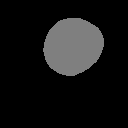

In [170]:
Image.fromarray(
    np.asarray(mask_rvm_all["202204020917510011VAS.nii.gz"]["both"][27], dtype=np.uint8)
    * 127
)

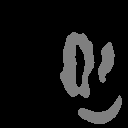

In [99]:
Image.fromarray(
    np.asarray(mask_rvm_all["_20210224093839_0943280.nii.gz"]["out"][0], dtype=np.uint8)
    * 127
)

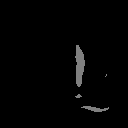

In [100]:
Image.fromarray(
    np.asarray(mask_rvm_all["_20210224093839_0943280.nii.gz"]["in"][0], dtype=np.uint8)
    * 127
)

In [20]:
# 保存AI选择的狭窄帧图像
if False:
    import os
    import shutil

    path = r"/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/dataset/0801_0815/dataset_1018/image"
    save_path = "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/狭窄帧_AI选图/"

    # 通过DFS实现统一逻辑处理同一层次的文件对象
    for root, dirs, files in os.walk(path):
        if not dirs:
            keywords = list(pne_rvm_max_index.keys())
            dir_name = root.split("/")[-1]
            if dir_name in keywords:
                # if not os.path.exists(save_path + dir_name):
                #     os.makedirs(save_path + dir_name)
                ext = ".png"
                start_index = int(
                    sorted([data for data in files if "._" not in data])[0].split(".")[
                        0
                    ]
                )
                for file_name in files:
                    if (
                        str(pne_rvm_max_index[dir_name] + start_index).zfill(4) + ext
                        == file_name
                    ):
                        image = cv2.imread(os.path.join(root, file_name))
                        cv2.imwrite(
                            os.path.join(
                                save_path,
                                f"{dir_name}_{pne_rvm_max_index[dir_name]+1}.png",
                            ),
                            image,
                        )

    print("运行结束")

运行结束


In [ ]:
# 狭窄率绘图
save_dir = f"/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/figs"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for idx in range(len(pne_all)):
    assert (
        sorted(list(pne_all.keys()))[idx]
        == sorted(list(pn_transbts_all.keys()))[idx]
        == sorted(list(pne_3dunet_all.keys()))[idx]
        == sorted(list(pne_rvm_all.keys()))[idx]
    )

    title = sorted(list(pne_all.keys()))[idx][:-7]

    fig_x = list(pne_all[sorted(list(pne_all.keys()))[idx]].index)
    fig_y = list(pne_all[sorted(list(pne_all.keys()))[idx]].values)

    fig_x_1 = list(pne_3dunet_all[sorted(list(pne_3dunet_all.keys()))[idx]].index)
    fig_y_1 = list(pne_3dunet_all[sorted(list(pne_3dunet_all.keys()))[idx]].values)

    fig_x_2 = list(pn_transbts_all[sorted(list(pn_transbts_all.keys()))[idx]].index)
    fig_y_2 = list(pn_transbts_all[sorted(list(pn_transbts_all.keys()))[idx]].values)

    fig_x_3 = list(pne_rvm_all[sorted(list(pne_rvm_all.keys()))[idx]].index)
    fig_y_3 = list(pne_rvm_all[sorted(list(pne_rvm_all.keys()))[idx]].values)

    plot.rcParams.update({"font.size": 14})
    plot.rcParams["font.sans-serif"] = ["Times New Roman"]
    fig = plot.figure(idx, figsize=(12, 6), dpi=300)
    ax = fig.add_subplot(111)

    ax.set(title=title, xlabel="frame", ylabel="diameter stenosis", ylim=[0, 1])

    ax.plot(fig_x, fig_y, "m", label="label")

    ax.plot(fig_x_1, fig_y_1, "g", label="3dunet")

    ax.plot(fig_x_2, fig_y_2, "c", label="transbts")

    ax.plot(fig_x_3, fig_y_3, "b", label="rvm")

    ax.legend()
    ax.grid(True)

    fig.savefig(f"{save_dir}/{title}.png")

In [51]:
def imgs2gif(imgPaths, saveName, duration=None, loop=0, fps=None):
    if fps:
        duration = 1 / fps
    duration *= 1000
    imgs = [Image.open(str(path)) for path in imgPaths]
    imgs[0].save(
        saveName, save_all=True, append_images=imgs, duration=duration, loop=loop
    )

In [55]:
path = "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/figs"
image_path_list = sorted(glob.glob(f"{path}/*.png"))
imgs2gif(image_path_list, "1.gif", 0.025, 1, 30)

In [89]:
path = "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/image/06570820220302_CA MASHAOYONG_20220302091109144.nii.gz"
raw_data = sitk.GetArrayFromImage(sitk.ReadImage(path))

raw_imgs = [
    cv2.resize(np.array(i), (128, 128), interpolation=cv2.INTER_NEAREST)
    for i in raw_data
]

rvm_data = sitk.GetArrayFromImage(sitk.ReadImage(path.replace("image", "rvm")))

imgs = []
for i, data in enumerate(rvm_data):
    frame_pad = np.pad(data, ((100, 100), (100, 100)), "constant", constant_values=0)
    frame_pad = cv2.morphologyEx(
        frame_pad, cv2.MORPH_CLOSE, kernel=np.ones((15, 15), np.uint8)
    )
    frame = frame_pad[100:-100, 100:-100]
    frame = remove_isolate(frame)
    mask_in = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
    mask_both = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)

    mask_in[frame == 2] = 1
    mask_both[frame != 0] = 1

    contours_in, hierarchy = cv2.findContours(
        np.array(mask_in, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    contours_both, hierarchy = cv2.findContours(
        np.array(mask_both, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )

    raw_frame = np.repeat(np.array(raw_imgs[i])[..., np.newaxis], 3, -1)

    temp = cv2.drawContours(raw_frame, contours_in, -1, (0, 255, 0), 1)
    img = cv2.drawContours(temp, contours_both, -1, (255, 0, 0), 1)

    imgs.append(Image.fromarray(np.array(img, dtype=np.uint8)))


imgs[0].save("1.gif", save_all=True, append_images=imgs, duration=1 / 30 * 1000, loop=1)

In [ ]:
save_dir = f"/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/figs"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for idx in range(len(x)):
    x = list(pne_rvm_all["06570820220302_CA MASHAOYONG_20220302091109144.nii.gz"].index)
    y = list(
        pne_rvm_all["06570820220302_CA MASHAOYONG_20220302091109144.nii.gz"].values
    )

    plot.rcParams.update({"font.size": 14})
    plot.rcParams["font.sans-serif"] = ["Times New Roman"]
    fig = plot.figure(idx, figsize=(6, 5), dpi=300)
    ax = fig.add_subplot(111)

    ax.set(
        title=title,
        xlabel="frame",
        ylabel="diameter stenosis",
        ylim=[0, 1],
        xlim=[-5, 90],
    )

    title = f"Predicted={y[idx]:.2f}"

    fig_x = x
    fig_y = y
    fig_y[idx + 1 :] = [nan] * (len(x) - idx - 1)
    ax.plot(fig_x, fig_y, "b", label="rvm")

    ax.legend()
    ax.grid(True)

    fig.savefig(f"{save_dir}/{idx}.png")

In [31]:
# 狭窄率曲线统计分析
r_dict = {}
dtw_dict = {}
ttest_dict = {}

for idx in range(len(pne_all)):
    assert (
        sorted(list(pne_all.keys()))[idx]
        == sorted(list(pn_transbts_all.keys()))[idx]
        == sorted(list(pne_3dunet_all.keys()))[idx]
        == sorted(list(pne_rvm_all.keys()))[idx]
    )

    title = sorted(list(pne_all.keys()))[idx][:-7]

    x = list(pne_all[sorted(list(pne_all.keys()))[idx]].values)

    x1 = list(pne_3dunet_all[sorted(list(pne_3dunet_all.keys()))[idx]].values)

    x2 = list(pn_transbts_all[sorted(list(pn_transbts_all.keys()))[idx]].values)

    x3 = list(pne_rvm_all[sorted(list(pne_rvm_all.keys()))[idx]].values)

    # 计算曲线相关性
    r_mat = np.corrcoef(np.array([x, x1, x2, x3]))
    r_mat_pd = pd.DataFrame(
        r_mat,
        index=[title, "3dunrt", "tranbts", "rvm"],
        columns=[title, "3dunrt", "tranbts", "rvm"],
    )
    r_dict[title] = r_mat_pd
    # 计算动态时间规整
    d1, _ = fastdtw(x, x1, dist=euclidean)
    d2, _ = fastdtw(x, x2, dist=euclidean)
    d3, _ = fastdtw(x, x3, dist=euclidean)
    dtw_list = [d1, d2, d3]
    dtw_pd = pd.DataFrame(dtw_list, index=["3dunrt", "tranbts", "rvm"], columns=[title])
    dtw_dict[title] = dtw_pd
    # 计算配对t检验(检验的是两配对样本差值的均值是否等于0)
    ttest1 = stats.ttest_rel(x, x1)
    ttest2 = stats.ttest_rel(x, x2)
    ttest3 = stats.ttest_rel(x, x3)
    ttest_mat = np.array([[nan, nan], list(ttest1), list(ttest2), list(ttest3)])
    ttest_mat_pd = pd.DataFrame(
        ttest_mat,
        index=[
            title,
            "3dunrt",
            "tranbts",
            "rvm",
        ],
        columns=["statistic", "pvalue"],
    )
    ttest_dict[title] = ttest_mat_pd

In [23]:
x = list(pne_all[sorted(list(pne_all.keys()))[0]].values)
x3 = list(pne_rvm_all[sorted(list(pne_rvm_all.keys()))[0]].values)

In [29]:
print((np.mean(x) - np.mean(x3)) / np.std(np.array(x) - np.array(x3)) * np.sqrt(len(x)))

stats.ttest_rel(x, x3)

-6.999760923657768


Ttest_relResult(statistic=-6.950981507606185, pvalue=1.4440521165386097e-09)

In [32]:
with pd.ExcelWriter(f"t配对检验.xlsx") as writer:
    pd.DataFrame().to_excel(writer)

with pd.ExcelWriter(f"t配对检验.xlsx") as writer:
    for idx, data in enumerate(ttest_dict.items()):
        data[1].to_excel(
            writer,
            sheet_name=f"Sheet{idx}",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

In [20]:
with pd.ExcelWriter(f"dtw距离.xlsx") as writer:
    pd.DataFrame().to_excel(writer)

with pd.ExcelWriter(f"dtw距离.xlsx") as writer:
    for idx, data in enumerate(dtw_dict.items()):
        data[1].to_excel(
            writer,
            sheet_name=f"Sheet{idx}",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

In [21]:
with pd.ExcelWriter(f"相关系数矩阵.xlsx") as writer:
    pd.DataFrame().to_excel(writer)

with pd.ExcelWriter(f"相关系数矩阵.xlsx") as writer:
    for idx, data in enumerate(r_dict.items()):
        data[1].to_excel(
            writer,
            sheet_name=f"Sheet{idx}",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

## 计算指标

In [6]:
def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [
            channel
            for channel in range(xs[0].shape[1])
            if channel not in ignore_channels
        ]
        xs = [
            torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device))
            for x in xs
        ]
        return xs


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x


class AccuracyProportion(nn.Module):
    def __init__(self, proportion=0.5, threshold=None, ignore_channels=None, eps=1e-7):
        super().__init__()
        self.proportion = proportion
        self.threshold = threshold
        self.ignore_channels = ignore_channels
        self.eps = eps

    def forward(self, pr, gt):
        assert pr.shape[0] == gt.shape[0]

        pr = _threshold(pr, threshold=self.threshold)
        pr, gt = _take_channels(pr, gt, ignore_channels=self.ignore_channels)

        sum_nums = pr.shape[0]
        nums = 0
        for idx in range(sum_nums):
            intersection = torch.sum(gt[idx] * pr[idx])
            union = torch.sum(gt[idx]) + torch.sum(pr[idx]) - intersection + self.eps
            score = (intersection + self.eps) / union

            if score > self.proportion:
                nums += 1
        ap_score = nums / sum_nums

        return ap_score


class ExpectedAverageOverlap(nn.Module):
    def __init__(self, threshold=None, ignore_channels=None, time_dim=0, eps=1e-7):
        super().__init__()
        self.threshold = threshold
        self.ignore_channels = ignore_channels
        self.time_dim = time_dim
        self.eps = eps

    def forward(self, pr, gt):
        assert pr.shape[self.time_dim] == gt.shape[self.time_dim]

        pr = _threshold(pr, threshold=self.threshold)
        pr, gt = _take_channels(pr, gt, ignore_channels=self.ignore_channels)

        nums = pr.shape[self.time_dim]
        score = 0
        for idx in range(nums):
            temp = 0
            for k in range(idx):
                tp = torch.sum((gt[k] == pr[k]).type(pr.dtype))
                temp += tp / (gt[k].view(-1).shape[0] + self.eps)

            score += temp / (idx + 1)
        eao_score = score / nums

        return eao_score


# 计算表面距离
def surface_distances(pr, gt, spacing):
    pr = np.atleast_1d(pr.astype(np.bool))
    gt = np.atleast_1d(gt.astype(np.bool))

    spacing = np.atleast_1d(spacing if spacing is not None else np.ones(pr.ndim))

    pr_edges = pr ^ ndimage.binary_erosion(pr)
    gt_edges = gt ^ ndimage.binary_erosion(gt)

    pr_points = np.argwhere(pr_edges)
    gt_points = np.argwhere(gt_edges)

    # Avoid calculation if one of the sets is empty
    if pr_points.size == 0 or gt_points.size == 0:
        return np.array([])

    distances = cdist(pr_points, gt_points, metric="euclidean")
    distances *= spacing

    return distances


def binary_asd(pr, gt, voxelspacing=None):
    distances = surface_distances(pr, gt, voxelspacing)
    if distances.size == 0:
        return np.nan  # Return NaN if distances array is empty
    return np.mean(np.min(distances, axis=1))


def binary_assd(pr, gt, voxelspacing=None):
    asd1 = binary_asd(pr, gt, voxelspacing)
    asd2 = binary_asd(gt, pr, voxelspacing)
    return (asd1 + asd2) / 2.0 if not np.isnan(asd1) and not np.isnan(asd2) else np.nan


def binary_hd(pr, gt, voxelspacing=None):
    distances = surface_distances(pr, gt, voxelspacing)
    if distances.size == 0:
        return np.nan
    return np.max(np.min(distances, axis=1))


def binary_hd95(pr, gt, voxelspacing=None):
    distances = surface_distances(pr, gt, voxelspacing)
    if distances.size == 0:
        return np.nan
    return np.percentile(np.min(distances, axis=1), 95)


class DistanceMetric(nn.Module):
    def __init__(
        self, method_name="hd", voxelspacing=None, threshold=None, ignore_channels=None
    ):
        super().__init__()
        self.method_name = method_name
        self.voxelspacing = voxelspacing
        self.threshold = threshold
        self.ignore_channels = ignore_channels

    def forward(self, pr, gt):
        assert len(pr.shape) == len(gt.shape) == 2, "输入数据应该是一个背景纯黑的面"

        pr = _threshold(pr, threshold=self.threshold)
        pr, gt = _take_channels(pr, gt, ignore_channels=self.ignore_channels)

        pr = pr.cpu().numpy()
        gt = gt.cpu().numpy()

        if self.method_name == "asd":
            distance_score = binary_asd(pr, gt, voxelspacing=self.voxelspacing)
        elif self.method_name == "assd":
            distance_score = binary_assd(pr, gt, voxelspacing=self.voxelspacing)
        elif self.method_name == "hd":
            distance_score = binary_hd(pr, gt, voxelspacing=self.voxelspacing)
        elif self.method_name == "hd95":
            distance_score = binary_hd95(pr, gt, voxelspacing=self.voxelspacing)
        else:
            print(f"方法{self.method_name}不存在，请设置方法为asd、assd、hd或hd95")
            sys.exit()

        return distance_score


def metric_functions(loss_name):
    if loss_name == "dice":
        return smp.utils.metrics.Fscore(beta=1, threshold=0.5)
    elif loss_name == "ac":
        return smp.utils.metrics.Accuracy(threshold=0.5)
    elif loss_name == "pre":
        return smp.utils.metrics.Precision(threshold=0.5)
    elif loss_name == "r":
        return smp.utils.metrics.Recall(threshold=0.5)
    elif loss_name == "f1":
        return smp.utils.metrics.Fscore(beta=1, threshold=0.5)
    elif loss_name == "iou":
        return smp.utils.metrics.IoU(threshold=0.5)
    elif loss_name == "ap@0.5":
        return AccuracyProportion(proportion=0.5, threshold=0.5)
    elif loss_name == "ap@0.7":
        return AccuracyProportion(proportion=0.7, threshold=0.5)
    elif loss_name == "eao":
        return ExpectedAverageOverlap(threshold=0.5)
    elif loss_name == "asd":
        return DistanceMetric(method_name="asd", threshold=0.5)
    elif loss_name == "assd":
        return DistanceMetric(method_name="assd", threshold=0.5)
    elif loss_name == "hd":
        return DistanceMetric(method_name="hd", threshold=0.5)
    elif loss_name == "hd95":
        return DistanceMetric(method_name="hd95", threshold=0.5)
    else:
        print("The loss function name: {} is invalid".format(loss_name))
        sys.exit()

In [12]:
def count_index(mask_data, mask_label, spacing_pixels, model_name, save_dir):
    dice_in_list = []
    dice_bothunique_list = []

    ac_in_list = []
    ac_bothunique_list = []

    pre_in_list = []
    pre_bothunique_list = []

    r_in_list = []
    r_bothunique_list = []

    f1_in_list = []
    f1_bothunique_list = []

    iou_in_list = []
    iou_bothunique_list = []

    ap_05_in_list = []
    ap_05_bothunique_list = []

    ap_07_in_list = []
    ap_07_bothunique_list = []

    eao_in_list = []
    eao_bothunique_list = []

    asd_in_list = []
    asd_bothunique_list = []

    assd_in_list = []
    assd_bothunique_list = []

    hd_in_list = []
    hd_bothunique_list = []

    hd95_in_list = []
    hd95_bothunique_list = []

    for i, file_name in enumerate(list(mask_data.keys())):
        data_in = mask_data[file_name]["in"]
        label_in = mask_label[file_name]["in"]
        data_both = mask_data[file_name]["both"]
        label_both = mask_label[file_name]["both"]

        data_in = torch.tensor(np.array(data_in))
        label_in = torch.tensor(np.array(label_in))
        data_both = torch.tensor(np.array(data_both))
        label_both = torch.tensor(np.array(label_both))

        if True:
            label_in = cv2.resize(
                np.array(label_in).transpose((1, 2, 0)),
                (128, 128),
                interpolation=cv2.INTER_NEAREST,
            ).transpose((2, 0, 1))
            label_in = torch.tensor(label_in).contiguous()
            label_both = cv2.resize(
                np.array(label_both).transpose((1, 2, 0)),
                (128, 128),
                interpolation=cv2.INTER_NEAREST,
            ).transpose((2, 0, 1))
            label_both = torch.tensor(label_both).contiguous()

        voxel = 5 / int(
            spacing_pixels[np.argwhere(spacing_pixels[:, 0] == file_name[:-7])][0][0][1]
        )

        if True:
            # 计算指标
            dice_in_all = metric_functions("dice")(data_in, label_in)
            dice_in_list.append(dice_in_all.cpu())
            dice_bothunique = metric_functions("dice")(data_both, label_both)
            dice_bothunique_list.append(dice_bothunique.cpu())

            ac_in = metric_functions("ac")(data_in, label_in)
            ac_in_list.append(ac_in.cpu())
            ac_bothunique = metric_functions("ac")(data_both, label_both)
            ac_bothunique_list.append(ac_bothunique.cpu())

            pre_in = metric_functions("pre")(data_in, label_in)
            pre_in_list.append(pre_in.cpu())
            pre_bothunique = metric_functions("pre")(data_both, label_both)
            pre_bothunique_list.append(pre_bothunique.cpu())

            r_in = metric_functions("r")(data_in, label_in)
            r_in_list.append(r_in.cpu())
            r_bothunique = metric_functions("r")(data_both, label_both)
            r_bothunique_list.append(r_bothunique.cpu())

            f1_in = metric_functions("f1")(data_in, label_in)
            f1_in_list.append(f1_in.cpu())
            f1_bothunique = metric_functions("f1")(data_both, label_both)
            f1_bothunique_list.append(f1_bothunique.cpu())

            iou_in = metric_functions("iou")(data_in, label_in)
            iou_in_list.append(iou_in.cpu())
            iou_bothunique = metric_functions("iou")(data_both, label_both)
            iou_bothunique_list.append(iou_bothunique.cpu())

            ap_05_in = metric_functions("ap@0.5")(data_in, label_in)
            ap_05_in_list.append(ap_05_in)
            ap_05_bothunique = metric_functions("ap@0.5")(data_both, label_both)
            ap_05_bothunique_list.append(ap_05_bothunique)

            ap_07_in = metric_functions("ap@0.7")(data_in, label_in)
            ap_07_in_list.append(ap_07_in)
            ap_07_bothunique = metric_functions("ap@0.7")(data_both, label_both)
            ap_07_bothunique_list.append(ap_07_bothunique)

            eao_in = metric_functions("eao")(data_in, label_in)
            eao_in_list.append(eao_in.cpu())
            eao_bothunique = metric_functions("eao")(data_both, label_both)
            eao_bothunique_list.append(eao_bothunique.cpu())

            asd_in = asd_bothunique = assd_in = assd_bothunique = hd_in = (
                hd_bothunique
            ) = hd95_in = hd95_bothunique = 0
            for j in range(data_in.shape[0]):
                asd_in += DistanceMetric(
                    method_name="asd", voxelspacing=voxel, threshold=0.5
                )(data_in[j], label_in[j])
                asd_bothunique += DistanceMetric(
                    method_name="asd", voxelspacing=voxel, threshold=0.5
                )(data_both[j], label_both[j])
                assd_in = DistanceMetric(
                    method_name="assd", voxelspacing=voxel, threshold=0.5
                )(data_in[j], label_in[j])
                assd_bothunique += DistanceMetric(
                    method_name="assd", voxelspacing=voxel, threshold=0.5
                )(data_both[j], label_both[j])
                hd_in += DistanceMetric(
                    method_name="hd", voxelspacing=voxel, threshold=0.5
                )(data_in[j], label_in[j])
                hd_bothunique += DistanceMetric(
                    method_name="hd", voxelspacing=voxel, threshold=0.5
                )(data_both[j], label_both[j])
                hd95_in += DistanceMetric(
                    method_name="hd95", voxelspacing=voxel, threshold=0.5
                )(data_in[j], label_in[j])
                hd95_bothunique += DistanceMetric(
                    method_name="hd95", voxelspacing=voxel, threshold=0.5
                )(data_both[j], label_both[j])

            asd_in_list.append(asd_in / data_in.shape[0])
            asd_bothunique_list.append(asd_bothunique / data_in.shape[0])
            assd_in_list.append(assd_in / data_in.shape[0])
            assd_bothunique_list.append(assd_bothunique / data_in.shape[0])
            hd_in_list.append(hd_in / data_in.shape[0])
            hd_bothunique_list.append(hd_bothunique / data_in.shape[0])
            hd95_in_list.append(hd95_in / data_in.shape[0])
            hd95_bothunique_list.append(hd95_bothunique / data_in.shape[0])

    if True:
        test_loss_dict = dict(
            {
                "dice_in": f"{np.array(dice_in_list).mean(axis=0):.2f}±{np.array(dice_in_list).std(axis=0):.2f}",
                "dice_bothunique": f"{np.array(dice_bothunique_list).mean(axis=0):.2f}±{np.array(dice_bothunique_list).std(axis=0):.2f}",
                "ac_in": f"{np.array(ac_in_list).mean(axis=0):.2f}±{np.array(ac_in_list).std(axis=0):.2f}",
                "ac_bothunique": f"{np.array(ac_bothunique_list).mean(axis=0):.2f}±{np.array(ac_bothunique_list).std(axis=0):.2f}",
                "pre_in": f"{np.array(pre_in_list).mean(axis=0):.2f}±{np.array(pre_in_list).std(axis=0):.2f}",
                "pre_bothunique": f"{np.array(pre_bothunique_list).mean(axis=0):.2f}±{np.array(pre_bothunique_list).std(axis=0):.2f}",
                "r_in": f"{np.array(r_in_list).mean(axis=0):.2f}±{np.array(r_in_list).std(axis=0):.2f}",
                "r_bothunique": f"{np.array(r_bothunique_list).mean(axis=0):.2f}±{np.array(r_bothunique_list).std(axis=0):.2f}",
                "f1_in": f"{np.array(f1_in_list).mean(axis=0):.2f}±{np.array(f1_in_list).std(axis=0):.2f}",
                "f1_bothunique": f"{np.array(f1_bothunique_list).mean(axis=0):.2f}±{np.array(f1_bothunique_list).std(axis=0):.2f}",
                "iou_in": f"{np.array(iou_in_list).mean(axis=0):.2f}±{np.array(iou_in_list).std(axis=0):.2f}",
                "iou_bothunique": f"{np.array(iou_bothunique_list).mean(axis=0):.2f}±{np.array(iou_bothunique_list).std(axis=0):.2f}",
                "ap@0.5_in": f"{np.array(ap_05_in_list).mean(axis=0):.2f}±{np.array(ap_05_in_list).std(axis=0):.2f}",
                "ap@0.5_bothunique": f"{np.array(ap_05_bothunique_list).mean(axis=0):.2f}±{np.array(ap_05_bothunique_list).std(axis=0):.2f}",
                "ap@0.7_in": f"{np.array(ap_07_in_list).mean(axis=0):.2f}±{np.array(ap_07_in_list).std(axis=0):.2f}",
                "ap@0.7_bothunique": f"{np.array(ap_07_bothunique_list).mean(axis=0):.2f}±{np.array(ap_07_bothunique_list).std(axis=0):.2f}",
                "eao_in": f"{np.array(eao_in_list).mean(axis=0):.2f}±{np.array(eao_in_list).std(axis=0):.2f}",
                "eao_bothunique": f"{np.array(eao_bothunique_list).mean(axis=0):.2f}±{np.array(eao_bothunique_list).std(axis=0):.2f}",
                "asd_in": f"{np.array(asd_in_list).mean(axis=0):.2f}±{np.array(asd_in_list).std(axis=0):.2f}",
                "asd_bothunique": f"{np.array(asd_bothunique_list).mean(axis=0):.2f}±{np.array(asd_bothunique_list).std(axis=0):.2f}",
                "assd_in": f"{np.array(assd_in_list).mean(axis=0):.2f}±{np.array(assd_in_list).std(axis=0):.2f}",
                "assd_bothunique": f"{np.array(assd_bothunique_list).mean(axis=0):.2f}±{np.array(assd_bothunique_list).std(axis=0):.2f}",
                "hd_in": f"{np.array(hd_in_list).mean(axis=0):.2f}±{np.array(hd_in_list).std(axis=0):.2f}",
                "hd_bothunique": f"{np.array(hd_bothunique_list).mean(axis=0):.2f}±{np.array(hd_bothunique_list).std(axis=0):.2f}",
                "hd95_in": f"{np.array(hd95_in_list).mean(axis=0):.2f}±{np.array(hd95_in_list).std(axis=0):.2f}",
                "hd95_bothunique": f"{np.array(hd95_bothunique_list).mean(axis=0):.2f}±{np.array(hd95_bothunique_list).std(axis=0):.2f}",
            }
        )

        if True:
            values = np.stack(
                [
                    dice_in_list,
                    dice_bothunique_list,
                    ac_in_list,
                    ac_bothunique_list,
                    pre_in_list,
                    pre_bothunique_list,
                    r_in_list,
                    r_bothunique_list,
                    f1_in_list,
                    f1_bothunique_list,
                    iou_in_list,
                    iou_bothunique_list,
                    ap_05_in_list,
                    ap_05_bothunique_list,
                    ap_07_in_list,
                    ap_07_bothunique_list,
                    eao_in_list,
                    eao_bothunique_list,
                    asd_in_list,
                    asd_bothunique_list,
                    assd_in_list,
                    assd_bothunique_list,
                    hd_in_list,
                    hd_bothunique_list,
                    hd95_in_list,
                    hd95_bothunique_list,
                ]
            )
            index = [
                "dice内膜",
                "dice外膜",
                "ac内膜",
                "ac外膜",
                "pre内膜",
                "pre外膜",
                "r内膜",
                "r外膜",
                "f1内膜",
                "f1外膜",
                "iou内膜",
                "iou外膜",
                "ap_05内膜",
                "ap_05外膜",
                "ap_07内膜",
                "ap_07外膜",
                "eao内膜",
                "eao外膜",
                "asd内膜",
                "asd外膜",
                "assd内膜",
                "assd外膜",
                "hd内膜",
                "hd外膜",
                "hd95内膜",
                "hd95外膜",
            ]
            columns = list(mask_data.keys())
            df = pd.DataFrame(values, index=index, columns=columns)
            with pd.ExcelWriter(f"{save_dir}/{model_name}_detail.xlsx") as writer:
                df.to_excel(
                    writer,
                    sheet_name="Sheet1",
                    index=True,
                    header=True,
                    startrow=0,
                    startcol=0,
                )

        if True:
            df = pd.DataFrame(test_loss_dict, index=["均值±标准差"])
            with pd.ExcelWriter(f"{save_dir}/{model_name}.xlsx") as writer:
                df.to_excel(
                    writer,
                    sheet_name="Sheet1",
                    index=True,
                    header=True,
                    startrow=0,
                    startcol=0,
                )

        print(test_loss_dict)


model_name = "transbts"
save_dir = "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/count_index"

spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

count_index(mask_transbts_all, mask_all, spacing_pixels, model_name, save_dir)

{'dice_in': '0.91±0.03', 'dice_bothunique': '0.89±0.03', 'ac_in': '0.00±0.00', 'ac_bothunique': '0.00±0.00', 'pre_in': '0.92±0.06', 'pre_bothunique': '0.94±0.05', 'r_in': '0.90±0.03', 'r_bothunique': '0.85±0.03', 'f1_in': '0.91±0.03', 'f1_bothunique': '0.89±0.03', 'iou_in': '0.84±0.05', 'iou_bothunique': '0.81±0.04', 'ap@0.5_in': '1.00±0.01', 'ap@0.5_bothunique': '0.99±0.02', 'ap@0.7_in': '0.92±0.12', 'ap@0.7_bothunique': '0.92±0.10', 'eao_in': '0.91±0.03', 'eao_bothunique': '0.88±0.04', 'asd_in': '0.23±0.10', 'asd_bothunique': '0.42±0.11', 'assd_in': '0.00±0.00', 'assd_bothunique': '0.30±0.08', 'hd_in': '0.68±0.34', 'hd_bothunique': '1.34±0.50', 'hd95_in': '0.55±0.28', 'hd95_bothunique': '0.97±0.34'}


In [81]:
image_path = "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/狭窄帧_人工选图_人工标注/image"
image_path_list = glob.glob(f"{image_path}/*.png")

image_ai_path = "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/狭窄帧_AI选图_人工标注/image"
image_ai_path_list = glob.glob(f"{image_ai_path}/*.png")

xiazhai_dict = {}
for ai_file in image_ai_path_list:
    ai_index = int(ai_file.split("/")[-1][:-4].split("_")[-1]) - 1
    name = ai_file.split("/")[-1][: -(4 + len(str(ai_index)) + 1)]
    # print(name, len(pne_all[f"{name}.nii.gz"]))

    label_index = list(pne_all[f"{name}.nii.gz"].values).index(
        max(pne_all[f"{name}.nii.gz"])
    )
    label_xz = pne_all[f"{name}.nii.gz"][label_index]
    # print("lab", label_index, label_xz)

    ai_xz = pne_all[f"{name}.nii.gz"][ai_index]
    # print("ai", ai_index, ai_xz)

    for file in image_path_list:
        if name in file:
            index = int(file.split("/")[-1][:-4].split("_")[-1]) - 1
            xz = pne_all[f"{name}.nii.gz"][index]
            # print("rg", index, xz)
            xiazhai_dict[name] = pd.DataFrame(
                [label_index, label_xz, ai_index, ai_xz, index, xz],
                index=[
                    "label狭窄帧索引",
                    "label狭窄帧狭窄率",
                    "ai狭窄帧索引",
                    "ai狭窄帧狭窄率",
                    "人工选帧狭窄帧索引",
                    "人工选帧狭窄帧狭窄率",
                ],
                columns=[name],
            )
        else:
            pass

In [82]:
with pd.ExcelWriter(f"123.xlsx") as writer:
    pd.DataFrame().to_excel(writer)

with pd.ExcelWriter(f"123.xlsx") as writer:
    for idx, data in enumerate(xiazhai_dict.items()):
        data[1].to_excel(
            writer,
            sheet_name=f"Sheet{idx}",
            index=True,
            header=True,
            startrow=0,
            startcol=0,
        )

In [72]:
xiazhai_dict["202203241105420022VAS"]

[173, 0.686536400362767, 173, 0.686536400362767, 172, 0.6647607836542504]

In [99]:
a = torch.tensor(mask_3dunet_all["_20210128075939_0818310.nii.gz"]["in"])
b = torch.tensor(mask_rvm_all["_20210128075939_0818310.nii.gz"]["in"])
c = cv2.resize(
    np.array(a).transpose((1, 2, 0)), (128, 128), interpolation=cv2.INTER_NEAREST
).transpose((2, 0, 1))

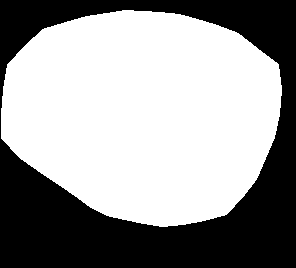

In [80]:
Image.fromarray(
    np.array(
        mask_all["_20210128075939_0818310.nii.gz"]["both"][0] * 255, dtype=np.uint8
    )
)

In [20]:
def volume_bounding_box(gt, expend=20):
    print(gt.shape)
    mask = gt != 0
    brain_voxels = np.where(mask != 0)
    z, x, y = gt.shape

    minZidx = int(np.min(brain_voxels[0]))
    maxZidx = int(np.max(brain_voxels[0]))
    minXidx = int(np.min(brain_voxels[1]))
    maxXidx = int(np.max(brain_voxels[1]))
    minYidx = int(np.min(brain_voxels[2]))
    maxYidx = int(np.max(brain_voxels[2]))

    minZidx_jitterd = max(minZidx - expend, 0)
    maxZidx_jitterd = min(maxZidx + expend, z) + 1
    minXidx_jitterd = max(minXidx - expend, 0)
    maxXidx_jitterd = min(maxXidx + expend, x) + 1
    minYidx_jitterd = max(minYidx - expend, 0)
    maxYidx_jitterd = min(maxYidx + expend, y) + 1

    gt_bboxed = [
        minZidx_jitterd,
        maxZidx_jitterd,
        minXidx_jitterd,
        maxXidx_jitterd,
        minYidx_jitterd,
        maxYidx_jitterd,
    ]

    print(gt_bboxed)

    return gt_bboxed

In [40]:
# 根据label获取roi坐标
filePath = "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/dataset/0810/label"

gt_dict = {}
for root, dirs, files in os.walk(filePath):
    if not dirs:
        name = f"{root.split('/')[-1]}.nii.gz"
        if name in file_list:
            gt = []
            for idx in sorted(files):
                if "._" not in idx:
                    label = cv2.imdecode(
                        np.fromfile(f"{root}/{idx}", dtype=np.uint8), -1
                    )
                    mask = np.zeros(
                        (
                            label.shape[0],
                            label.shape[1],
                        ),
                        dtype=np.uint8,
                    )
                    mask[np.sum(label, axis=-1) > 0] = 1
                    gt.append(mask)
            gt = np.array(gt)
            coordinate = volume_bounding_box(gt, 0)
            gt_dict[name] = coordinate

print("运行结束")

(198, 910, 1260)
[0, 198, 331, 492, 460, 656]
(254, 672, 896)
[0, 254, 269, 433, 343, 553]
(98, 672, 896)
[0, 98, 306, 465, 386, 549]
(196, 600, 800)
[0, 196, 233, 424, 311, 598]
(151, 600, 800)
[0, 151, 261, 364, 382, 534]
(151, 600, 800)
[0, 151, 239, 409, 288, 509]
(70, 910, 1260)
[0, 70, 308, 467, 476, 640]
(161, 600, 800)
[0, 161, 231, 374, 444, 638]
(151, 600, 800)
[0, 151, 240, 417, 303, 592]
(151, 600, 800)
[0, 151, 276, 392, 257, 430]
(143, 600, 800)
[0, 143, 255, 355, 436, 569]
(137, 600, 800)
[0, 137, 194, 329, 241, 530]
(86, 600, 800)
[0, 86, 156, 280, 328, 492]
(116, 600, 800)
[0, 116, 158, 274, 357, 550]
(41, 910, 1260)
[0, 41, 322, 558, 388, 601]
(45, 672, 896)
[0, 45, 226, 323, 348, 526]
(161, 672, 896)
[0, 161, 259, 412, 409, 635]
(286, 672, 896)
[0, 286, 198, 379, 245, 480]
(77, 672, 896)
[0, 77, 221, 488, 412, 714]
(47, 672, 896)
[0, 47, 211, 399, 413, 787]
(113, 672, 896)
[0, 113, 271, 474, 226, 435]
(78, 672, 896)
[0, 78, 215, 420, 412, 606]
(174, 672, 896)
[0, 174

In [64]:
gt_dict.keys()

dict_keys(['202204110951560016VAS.nii.gz', '202204070858070033VAS.nii.gz', '202203241107360023VAS.nii.gz', 'IM_0010.nii.gz', 'IM_0033.nii.gz', 'IM_0039.nii.gz', '202203081456170036VAS.nii.gz', 'IM_0079.nii.gz', 'IM_0084.nii.gz', 'IM_0049.nii.gz', 'IM_0061.nii.gz', 'IM_0044.nii.gz', '06570820220302_CA MASHAOYONG_20220302091109144.nii.gz', '06570820220302_CA MASHAOYONG_20220302091057736.nii.gz', '202203140858390011VAS.nii.gz', '202203141429300009VAS.nii.gz', '24060820210210_SMY_20210210081527458.nii.gz', '29081020210319_YZX_20210319101543139.nii.gz', '_20210128075939_0818310.nii.gz', '_20210224093839_0943280.nii.gz', '202203211455210024VAS.nii.gz', '02220820210305_XJ_20210305082931543.nii.gz', '202203241105420022VAS.nii.gz', '202203251425020010VAS.nii.gz', '202204020917510011VAS.nii.gz', '39561320210331_DJF_20210331140409947.nii.gz', '43291020210205_CQH_20210205103732049.nii.gz'])

In [45]:
name = file_list[3]
print(gt_dict[name])
print(
    gt_dict[name][1] - gt_dict[name][0],
    gt_dict[name][3] - gt_dict[name][2],
    gt_dict[name][5] - gt_dict[name][4],
)

[0, 47, 211, 399, 413, 787]
47 188 374


In [47]:
path = f"/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/label/{name}"

a = sitk.GetArrayFromImage(sitk.ReadImage(path))
b = a[0, ...]

In [98]:
def count_xuanzhen_index(mask_data, mask_label, spacing_pixels, model_name, save_dir):
    dice_in_list = []
    dice_bothunique_list = []

    ac_in_list = []
    ac_bothunique_list = []

    pre_in_list = []
    pre_bothunique_list = []

    r_in_list = []
    r_bothunique_list = []

    f1_in_list = []
    f1_bothunique_list = []

    iou_in_list = []
    iou_bothunique_list = []

    ap_05_in_list = []
    ap_05_bothunique_list = []

    ap_07_in_list = []
    ap_07_bothunique_list = []

    eao_in_list = []
    eao_bothunique_list = []

    asd_in_list = []
    asd_bothunique_list = []

    assd_in_list = []
    assd_bothunique_list = []

    hd_in_list = []
    hd_bothunique_list = []

    hd95_in_list = []
    hd95_bothunique_list = []

    for i, file_name in enumerate(list(mask_data.keys())):
        data_in = mask_data[file_name]["in"]
        label_in = mask_label[file_name]["in"]
        data_both = mask_data[file_name]["both"]
        label_both = mask_label[file_name]["both"]

        data_in = torch.tensor(np.array(data_in))
        label_in = torch.tensor(np.array(label_in))
        data_both = torch.tensor(np.array(data_both))
        label_both = torch.tensor(np.array(label_both))

        if True:
            label_in = [
                cv2.resize(
                    np.array(label_in).transpose((1, 2, 0)),
                    (128, 128),
                    interpolation=cv2.INTER_NEAREST,
                )
            ]
            label_in = torch.tensor(label_in).contiguous()
            label_both = [
                cv2.resize(
                    np.array(label_both).transpose((1, 2, 0)),
                    (128, 128),
                    interpolation=cv2.INTER_NEAREST,
                )
            ]
            label_both = torch.tensor(label_both).contiguous()

            data_in = [
                cv2.resize(
                    np.array(data_in).transpose((1, 2, 0)),
                    (128, 128),
                    interpolation=cv2.INTER_NEAREST,
                )
            ]
            data_in = torch.tensor(data_in).contiguous()
            data_both = [
                cv2.resize(
                    np.array(data_both).transpose((1, 2, 0)),
                    (128, 128),
                    interpolation=cv2.INTER_NEAREST,
                )
            ]
            data_both = torch.tensor(data_both).contiguous()

        voxel = 5 / int(
            spacing_pixels[np.argwhere(spacing_pixels[:, 0] == file_name)][0][0][1]
        )

        if True:
            # 计算指标
            dice_in_all = metric_functions("dice")(data_in, label_in)
            dice_in_list.append(dice_in_all.cpu())
            dice_bothunique = metric_functions("dice")(data_both, label_both)
            dice_bothunique_list.append(dice_bothunique.cpu())

            ac_in = metric_functions("ac")(data_in, label_in)
            ac_in_list.append(ac_in.cpu())
            ac_bothunique = metric_functions("ac")(data_both, label_both)
            ac_bothunique_list.append(ac_bothunique.cpu())

            pre_in = metric_functions("pre")(data_in, label_in)
            pre_in_list.append(pre_in.cpu())
            pre_bothunique = metric_functions("pre")(data_both, label_both)
            pre_bothunique_list.append(pre_bothunique.cpu())

            r_in = metric_functions("r")(data_in, label_in)
            r_in_list.append(r_in.cpu())
            r_bothunique = metric_functions("r")(data_both, label_both)
            r_bothunique_list.append(r_bothunique.cpu())

            f1_in = metric_functions("f1")(data_in, label_in)
            f1_in_list.append(f1_in.cpu())
            f1_bothunique = metric_functions("f1")(data_both, label_both)
            f1_bothunique_list.append(f1_bothunique.cpu())

            iou_in = metric_functions("iou")(data_in, label_in)
            iou_in_list.append(iou_in.cpu())
            iou_bothunique = metric_functions("iou")(data_both, label_both)
            iou_bothunique_list.append(iou_bothunique.cpu())

            ap_05_in = metric_functions("ap@0.5")(data_in, label_in)
            ap_05_in_list.append(ap_05_in)
            ap_05_bothunique = metric_functions("ap@0.5")(data_both, label_both)
            ap_05_bothunique_list.append(ap_05_bothunique)

            ap_07_in = metric_functions("ap@0.7")(data_in, label_in)
            ap_07_in_list.append(ap_07_in)
            ap_07_bothunique = metric_functions("ap@0.7")(data_both, label_both)
            ap_07_bothunique_list.append(ap_07_bothunique)

            eao_in = metric_functions("eao")(data_in, label_in)
            eao_in_list.append(eao_in)
            eao_bothunique = metric_functions("eao")(data_both, label_both)
            eao_bothunique_list.append(eao_bothunique)

            asd_in = asd_bothunique = assd_in = assd_bothunique = hd_in = (
                hd_bothunique
            ) = hd95_in = hd95_bothunique = 0
            for j in range(data_in.shape[0]):
                print(data_in.shape, label_in.shape)
                asd_in += DistanceMetric(
                    method_name="asd", voxelspacing=voxel, threshold=0.5
                )(data_in[j], label_in[j])
                asd_bothunique += DistanceMetric(
                    method_name="asd", voxelspacing=voxel, threshold=0.5
                )(data_both[j], label_both[j])
                assd_in = DistanceMetric(
                    method_name="assd", voxelspacing=voxel, threshold=0.5
                )(data_in[j], label_in[j])
                assd_bothunique += DistanceMetric(
                    method_name="assd", voxelspacing=voxel, threshold=0.5
                )(data_both[j], label_both[j])
                hd_in += DistanceMetric(
                    method_name="hd", voxelspacing=voxel, threshold=0.5
                )(data_in[j], label_in[j])
                hd_bothunique += DistanceMetric(
                    method_name="hd", voxelspacing=voxel, threshold=0.5
                )(data_both[j], label_both[j])
                hd95_in += DistanceMetric(
                    method_name="hd95", voxelspacing=voxel, threshold=0.5
                )(data_in[j], label_in[j])
                hd95_bothunique += DistanceMetric(
                    method_name="hd95", voxelspacing=voxel, threshold=0.5
                )(data_both[j], label_both[j])

            asd_in_list.append(asd_in / data_in.shape[0])
            asd_bothunique_list.append(asd_bothunique / data_in.shape[0])
            assd_in_list.append(assd_in / data_in.shape[0])
            assd_bothunique_list.append(assd_bothunique / data_in.shape[0])
            hd_in_list.append(hd_in / data_in.shape[0])
            hd_bothunique_list.append(hd_bothunique / data_in.shape[0])
            hd95_in_list.append(hd95_in / data_in.shape[0])
            hd95_bothunique_list.append(hd95_bothunique / data_in.shape[0])

    if True:
        test_loss_dict = dict(
            {
                "dice_in": f"{np.array(dice_in_list).mean(axis=0):.2f}±{np.array(dice_in_list).std(axis=0):.2f}",
                "dice_bothunique": f"{np.array(dice_bothunique_list).mean(axis=0):.2f}±{np.array(dice_bothunique_list).std(axis=0):.2f}",
                "ac_in": f"{np.array(ac_in_list).mean(axis=0):.2f}±{np.array(ac_in_list).std(axis=0):.2f}",
                "ac_bothunique": f"{np.array(ac_bothunique_list).mean(axis=0):.2f}±{np.array(ac_bothunique_list).std(axis=0):.2f}",
                "pre_in": f"{np.array(pre_in_list).mean(axis=0):.2f}±{np.array(pre_in_list).std(axis=0):.2f}",
                "pre_bothunique": f"{np.array(pre_bothunique_list).mean(axis=0):.2f}±{np.array(pre_bothunique_list).std(axis=0):.2f}",
                "r_in": f"{np.array(r_in_list).mean(axis=0):.2f}±{np.array(r_in_list).std(axis=0):.2f}",
                "r_bothunique": f"{np.array(r_bothunique_list).mean(axis=0):.2f}±{np.array(r_bothunique_list).std(axis=0):.2f}",
                "f1_in": f"{np.array(f1_in_list).mean(axis=0):.2f}±{np.array(f1_in_list).std(axis=0):.2f}",
                "f1_bothunique": f"{np.array(f1_bothunique_list).mean(axis=0):.2f}±{np.array(f1_bothunique_list).std(axis=0):.2f}",
                "iou_in": f"{np.array(iou_in_list).mean(axis=0):.2f}±{np.array(iou_in_list).std(axis=0):.2f}",
                "iou_bothunique": f"{np.array(iou_bothunique_list).mean(axis=0):.2f}±{np.array(iou_bothunique_list).std(axis=0):.2f}",
                "ap@0.5_in": f"{np.array(ap_05_in_list).mean(axis=0):.2f}±{np.array(ap_05_in_list).std(axis=0):.2f}",
                "ap@0.5_bothunique": f"{np.array(ap_05_bothunique_list).mean(axis=0):.2f}±{np.array(ap_05_bothunique_list).std(axis=0):.2f}",
                "ap@0.7_in": f"{np.array(ap_07_in_list).mean(axis=0):.2f}±{np.array(ap_07_in_list).std(axis=0):.2f}",
                "ap@0.7_bothunique": f"{np.array(ap_07_bothunique_list).mean(axis=0):.2f}±{np.array(ap_07_bothunique_list).std(axis=0):.2f}",
                "eao_in": f"{np.array(eao_in_list).mean(axis=0):.2f}±{np.array(eao_in_list).std(axis=0):.2f}",
                "eao_bothunique": f"{np.array(eao_bothunique_list).mean(axis=0):.2f}±{np.array(eao_bothunique_list).std(axis=0):.2f}",
                "asd_in": f"{np.array(asd_in_list).mean(axis=0):.2f}±{np.array(asd_in_list).std(axis=0):.2f}",
                "asd_bothunique": f"{np.array(asd_bothunique_list).mean(axis=0):.2f}±{np.array(asd_bothunique_list).std(axis=0):.2f}",
                "assd_in": f"{np.array(assd_in_list).mean(axis=0):.2f}±{np.array(assd_in_list).std(axis=0):.2f}",
                "assd_bothunique": f"{np.array(assd_bothunique_list).mean(axis=0):.2f}±{np.array(assd_bothunique_list).std(axis=0):.2f}",
                "hd_in": f"{np.array(hd_in_list).mean(axis=0):.2f}±{np.array(hd_in_list).std(axis=0):.2f}",
                "hd_bothunique": f"{np.array(hd_bothunique_list).mean(axis=0):.2f}±{np.array(hd_bothunique_list).std(axis=0):.2f}",
                "hd95_in": f"{np.array(hd95_in_list).mean(axis=0):.2f}±{np.array(hd95_in_list).std(axis=0):.2f}",
                "hd95_bothunique": f"{np.array(hd95_bothunique_list).mean(axis=0):.2f}±{np.array(hd95_bothunique_list).std(axis=0):.2f}",
            }
        )

        if True:
            values = np.stack(
                [
                    dice_in_list,
                    dice_bothunique_list,
                    ac_in_list,
                    ac_bothunique_list,
                    pre_in_list,
                    pre_bothunique_list,
                    r_in_list,
                    r_bothunique_list,
                    f1_in_list,
                    f1_bothunique_list,
                    iou_in_list,
                    iou_bothunique_list,
                    ap_05_in_list,
                    ap_05_bothunique_list,
                    ap_07_in_list,
                    ap_07_bothunique_list,
                    eao_in_list,
                    eao_bothunique_list,
                    asd_in_list,
                    asd_bothunique_list,
                    assd_in_list,
                    assd_bothunique_list,
                    hd_in_list,
                    hd_bothunique_list,
                    hd95_in_list,
                    hd95_bothunique_list,
                ]
            )
            index = [
                "dice内膜",
                "dice外膜",
                "ac内膜",
                "ac外膜",
                "pre内膜",
                "pre外膜",
                "r内膜",
                "r外膜",
                "f1内膜",
                "f1外膜",
                "iou内膜",
                "iou外膜",
                "ap_05内膜",
                "ap_05外膜",
                "ap_07内膜",
                "ap_07外膜",
                "eao内膜",
                "eao外膜",
                "asd内膜",
                "asd外膜",
                "assd内膜",
                "assd外膜",
                "hd内膜",
                "hd外膜",
                "hd95内膜",
                "hd95外膜",
            ]
            columns = list(mask_data.keys())
            df = pd.DataFrame(values, index=index, columns=columns)
            with pd.ExcelWriter(f"{save_dir}/{model_name}_detail.xlsx") as writer:
                df.to_excel(
                    writer,
                    sheet_name="Sheet1",
                    index=True,
                    header=True,
                    startrow=0,
                    startcol=0,
                )

        if True:
            df = pd.DataFrame(test_loss_dict, index=["均值±标准差"])
            with pd.ExcelWriter(f"{save_dir}/{model_name}.xlsx") as writer:
                df.to_excel(
                    writer,
                    sheet_name="Sheet1",
                    index=True,
                    header=True,
                    startrow=0,
                    startcol=0,
                )

        print(test_loss_dict)

In [124]:
ai_path = "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/狭窄帧_AI选图_人工标注/label"
ai_label_path_list = glob.glob(f"{ai_path}/*.png")

spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

# ai选帧人工标注结果的准确性对比ai标注的结果
xuanzhen_ai_mask_all = {}
xuanzhen_ai_label_mask_all = {}
xuanzhen_ai_rvm_mask_all = {}
for idx, ai_file in enumerate(ai_label_path_list):
    ai_index = int(ai_file.split("/")[-1][:-4].split("_")[-1]) - 1
    name = ai_file.split("/")[-1][: -(4 + len(str(ai_index)) + 1)]
    coordinate = gt_dict[f"{name}.nii.gz"]
    label = cv2.imread(ai_file)[
        coordinate[2] : coordinate[3], coordinate[4] : coordinate[5]
    ]
    data = np.zeros(
        (
            label.shape[0],
            label.shape[1],
        ),
        dtype=np.uint8,
    )

    data[label[:, :, 1] == 255] = 2
    data[label[:, :, 2] == 255] = 1

    spacing = int(spacing_pixels[np.argwhere(spacing_pixels[:, 0] == name)][0][0][1])

    mask = {}
    mask_out_list = []
    mask_in_list = []
    mask_both_list = []
    mask_both_erode_list = []

    mask_label = {}
    mask_rvm = {}

    out_mask = np.zeros_like(data)
    out_mask[data == 1] = 1  # 环形mask
    in_mask = np.zeros_like(data)
    in_mask[data == 2] = 1  # 内膜mask
    both_mask = out_mask + in_mask  # 外膜mask
    both_mask_erode = cv2.erode(
        both_mask, kernel=(3, 3), iterations=spacing // 10
    )  # 外膜腐蚀mask

    mask_out_list.append(out_mask)
    mask_in_list.append(in_mask)
    mask_both_list.append(both_mask)
    mask_both_erode_list.append(both_mask_erode)

    mask["out"] = mask_out_list
    mask["in"] = mask_in_list
    mask["both"] = mask_both_list
    mask["both_erode"] = mask_both_erode_list

    mask_label["out"] = [mask_all[f"{name}.nii.gz"]["out"][ai_index]]
    mask_label["in"] = [mask_all[f"{name}.nii.gz"]["in"][ai_index]]
    mask_label["both"] = [mask_all[f"{name}.nii.gz"]["both"][ai_index]]
    mask_label["both_erode"] = [mask_all[f"{name}.nii.gz"]["both_erode"][ai_index]]

    mask_rvm["out"] = [mask_rvm_all[f"{name}.nii.gz"]["out"][ai_index]]
    mask_rvm["in"] = [mask_rvm_all[f"{name}.nii.gz"]["in"][ai_index]]
    mask_rvm["both"] = [mask_rvm_all[f"{name}.nii.gz"]["both"][ai_index]]
    mask_rvm["both_erode"] = [mask_rvm_all[f"{name}.nii.gz"]["both_erode"][ai_index]]

    xuanzhen_ai_mask_all[name] = mask
    xuanzhen_ai_label_mask_all[name] = mask_label
    xuanzhen_ai_rvm_mask_all[name] = mask_rvm

In [115]:
path = "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/狭窄帧_人工选图_人工标注/label"
label_path_list = glob.glob(f"{path}/*.png")

spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

# 人工选帧人工标注结果的准确性对比ai标注的结果
xuanzhen_mask_all = {}
xuanzhen_label_mask_all = {}
xuanzhen_rvm_mask_all = {}
for idx, file in enumerate(label_path_list):
    index = int(file.split("/")[-1][:-4].split("_")[-1]) - 1
    name = file.split("/")[-1][: -(4 + len(str(index)) + 1)]

    coordinate = gt_dict[f"{name}.nii.gz"]
    label = cv2.imread(file)[
        coordinate[2] : coordinate[3], coordinate[4] : coordinate[5]
    ]
    print(name, label.shape)

    data = np.zeros(
        (
            label.shape[0],
            label.shape[1],
        ),
        dtype=np.uint8,
    )

    data[label[:, :, 1] == 255] = 2
    data[label[:, :, 2] == 255] = 1

    spacing = int(spacing_pixels[np.argwhere(spacing_pixels[:, 0] == name)][0][0][1])

    mask = {}
    mask_out_list = []
    mask_in_list = []
    mask_both_list = []
    mask_both_erode_list = []

    mask_label = {}
    mask_rvm = {}

    out_mask = np.zeros_like(data)
    out_mask[data == 1] = 1  # 环形mask
    in_mask = np.zeros_like(data)
    in_mask[data == 2] = 1  # 内膜mask
    both_mask = out_mask + in_mask  # 外膜mask
    both_mask_erode = cv2.erode(
        both_mask, kernel=(3, 3), iterations=spacing // 10
    )  # 外膜腐蚀mask

    mask_out_list.append(out_mask)
    mask_in_list.append(in_mask)
    mask_both_list.append(both_mask)
    mask_both_erode_list.append(both_mask_erode)

    mask["out"] = mask_out_list
    mask["in"] = mask_in_list
    mask["both"] = mask_both_list
    mask["both_erode"] = mask_both_erode_list

    mask_label["out"] = [mask_all[f"{name}.nii.gz"]["out"][index]]
    mask_label["in"] = [mask_all[f"{name}.nii.gz"]["in"][index]]
    mask_label["both"] = [mask_all[f"{name}.nii.gz"]["both"][index]]
    mask_label["both_erode"] = [mask_all[f"{name}.nii.gz"]["both_erode"][index]]

    mask_rvm["out"] = [mask_rvm_all[f"{name}.nii.gz"]["out"][index]]
    mask_rvm["in"] = [mask_rvm_all[f"{name}.nii.gz"]["in"][index]]
    mask_rvm["both"] = [mask_rvm_all[f"{name}.nii.gz"]["both"][index]]
    mask_rvm["both_erode"] = [mask_rvm_all[f"{name}.nii.gz"]["both_erode"][index]]

    xuanzhen_mask_all[name] = mask
    xuanzhen_label_mask_all[name] = mask_label
    xuanzhen_rvm_mask_all[name] = mask_rvm

202204110951560016VAS (161, 196, 3)
202203241105420022VAS (194, 163, 3)
43291020210205_CQH_20210205103732049 (176, 233, 3)
06570820220302_CA MASHAOYONG_20220302091057736 (116, 193, 3)
202203251425020010VAS (134, 236, 3)
202204070858070033VAS (164, 210, 3)
202203140858390011VAS (236, 213, 3)
_20210128075939_0818310 (267, 302, 3)
24060820210210_SMY_20210210081527458 (153, 226, 3)
IM_0084 (177, 289, 3)
202203081456170036VAS (159, 164, 3)
02220820210305_XJ_20210305082931543 (205, 194, 3)
202203241107360023VAS (159, 163, 3)
IM_0061 (100, 133, 3)
IM_0010 (191, 287, 3)
29081020210319_YZX_20210319101543139 (181, 235, 3)
202203141429300009VAS (97, 178, 3)
_20210224093839_0943280 (188, 374, 3)
06570820220302_CA MASHAOYONG_20220302091109144 (124, 164, 3)
202203211455210024VAS (203, 209, 3)
39561320210331_DJF_20210331140409947 (173, 272, 3)
202204020917510011VAS (191, 240, 3)


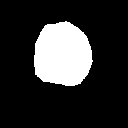

In [119]:
Image.fromarray(
    cv2.resize(
        xuanzhen_mask_all["_20210224093839_0943280"]["in"][0],
        (128, 128),
        interpolation=cv2.INTER_NEAREST,
    )
    * 255
)

# xuanzhen_ai_mask_all['202203141429300009VAS']['in'][0].shape

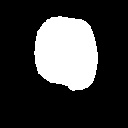

In [120]:
Image.fromarray(
    cv2.resize(
        xuanzhen_label_mask_all["_20210224093839_0943280"]["in"][0],
        (128, 128),
        interpolation=cv2.INTER_NEAREST,
    )
    * 255
)
# xuanzhen_ai_label_mask_all['202203141429300009VAS']['in'][0].shape

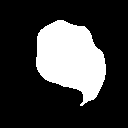

In [121]:
Image.fromarray(
    np.array(xuanzhen_rvm_mask_all["_20210224093839_0943280"]["in"][0], dtype=np.uint8)
    * 255
)
# xuanzhen_ai_rvm_mask_all['202203141429300009VAS']['in'][0].shape

In [130]:
a1 = cv2.resize(
    np.array(xuanzhen_ai_rvm_mask_all["202203141429300009VAS"]["both"]).transpose(
        (1, 2, 0)
    ),
    (128, 128),
    interpolation=cv2.INTER_NEAREST,
)
a2 = cv2.resize(
    np.array(xuanzhen_ai_label_mask_all["202203141429300009VAS"]["both"]).transpose(
        (1, 2, 0)
    ),
    (128, 128),
    interpolation=cv2.INTER_NEAREST,
)
# np.array(xuanzhen_ai_rvm_mask_all['202203141429300009VAS']['in']).transpose((1, 2, 0)).shape
metric_functions("ac")(torch.tensor(a1), torch.tensor(a2))

tensor(0.9681)

In [111]:
xuanzhen_ai_mask_all.keys()

dict_keys(['_20210128075939_0818310', '_20210224093839_0943280', '02220820210305_XJ_20210305082931543', '06570820220302_CA MASHAOYONG_20220302091057736', '06570820220302_CA MASHAOYONG_20220302091109144', '24060820210210_SMY_20210210081527458', '29081020210319_YZX_20210319101543139', '39561320210331_DJF_20210331140409947', '43291020210205_CQH_20210205103732049', '202203081456170036VAS', '202203140858390011VAS', '202203141429300009VAS', '202203211455210024VAS', '202203241105420022VAS', '202203241107360023VAS', '202203251425020010VAS', '202204020917510011VAS', '202204070858070033VAS', '202204110951560016VAS', 'IM_0010', 'IM_0033', 'IM_0039', 'IM_0044', 'IM_0049', 'IM_0061', 'IM_0079', 'IM_0084'])

In [126]:
model_name = "选帧人工"
save_dir = "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/狭窄帧_AI选图_人工标注"

spacing_pixels = np.array(
    pd.read_excel(
        "/Volumes/昊大侠/工作/实习相关/微创卜算子医疗科技有限公司/陈嘉懿组/数据/短轴动态狭窄率/result/狭窄率图表_0920/测试集去除分叉帧数据及结果/动态测试集spacing.xlsx"
    ).values
)

count_xuanzhen_index(
    xuanzhen_ai_mask_all,
    xuanzhen_ai_label_mask_all,
    spacing_pixels,
    model_name,
    save_dir,
)

torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
torch.Size([